In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 500

In [19]:
import os
DIVERSITY_UTILITY = 0.25
FRAC_ADMIT = 0.5

###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test_large.csv')
df['key'] = df['R'].astype(str) + "_"  + df['T'].astype(str)

###
## Estimate E[Y(1)|T, A]
###

df_train = pd.read_csv('./df_train.csv')
df_stratum_utility = df_train[['R','T','Y']].groupby(['R','T']).mean().reset_index()
df_stratum_utility['utility_grad'] = (df_stratum_utility['Y']).round(2)
df_stratum_utility['stratum_utility'] = (df_stratum_utility['Y'] + DIVERSITY_UTILITY * df_stratum_utility['R']).round(2)
df_stratum_utility['key'] = df_stratum_utility['R'].astype(str) + "_" + df_stratum_utility['T'].astype(str)

df = df.merge(df_stratum_utility[['stratum_utility','utility_grad','key']], on='key')
df['ml_outcomes'] = df['stratum_utility']

In [20]:
TOTAL_ADMITS = int(len(df)*FRAC_ADMIT)


In [21]:
MAX_BLACK_ADMITS = len(df[df['R']==1])
MIN_GRADUATES = 100000
GRID_SIZE = 1000

In [22]:
outcomes_grid = []
Xs = []
Ys = []

for N_black_admits in range(0,MAX_BLACK_ADMITS):
    
    if N_black_admits % GRID_SIZE != 0:
        continue
    
    black_admits = df[df['R']==1].sort_values(by='T',ascending=False).head(n=N_black_admits)
    white_admits = df[df['R']==0].sort_values(by='T',ascending=False).head(n=TOTAL_ADMITS-N_black_admits)
    
    Y = black_admits['Y'].sum() + white_admits['Y'].sum()
    
    Xs.append(N_black_admits)
    Ys.append(Y)
    print(N_black_admits,Y)
    
    for y_iter in np.arange(MIN_GRADUATES,Y,GRID_SIZE):
        outcomes_grid.append({'min_black_admits':N_black_admits-GRID_SIZE/2, 'max_black_admits':N_black_admits+GRID_SIZE/2, 'max_graduates':y_iter+GRID_SIZE, 'min_graduates':y_iter, 'policy_exists':'Unknown'})
        

0 292727
1000 293296
2000 293843
3000 294349
4000 294802
5000 295230
6000 295649
7000 296056
8000 296503
9000 296899
10000 297279
11000 297608
12000 297984
13000 298366
14000 298683
15000 299052
16000 299370
17000 299701
18000 300000
19000 300286
20000 300621
21000 300901
22000 301169
23000 301426
24000 301701
25000 301922
26000 302190
27000 302463
28000 302703
29000 302921
30000 303166
31000 303429
32000 303662
33000 303795
34000 304003
35000 304205
36000 304398
37000 304581
38000 304794
39000 304999
40000 305171
41000 305375
42000 305568
43000 305731
44000 305871
45000 306003
46000 306174
47000 306344
48000 306459
49000 306588
50000 306677
51000 306780
52000 306852
53000 306973
54000 307127
55000 307270
56000 307404
57000 307504
58000 307630
59000 307771
60000 307881
61000 308000
62000 308099
63000 308173
64000 308242
65000 308299
66000 308385
67000 308412
68000 308486
69000 308508
70000 308521
71000 308536
72000 308593
73000 308654
74000 308704
75000 308708
76000 308768
77000 308775

In [23]:
df_pareto = pd.DataFrame({'# Black Admits':Xs, '# Graduates':Ys})

In [24]:
dff = df[['R','T','ml_outcomes','Y']].groupby(['R','T','Y']).count().reset_index()
dff.columns = ['R','T','Y','N']


In [25]:
from ortools.linear_solver import pywraplp
solver = pywraplp.Solver.CreateSolver('GLOP')


In [26]:
applicant_stratum = []
vars_cache = {}

# Objective: Maximize the expected utility of the admitted students
objective = solver.Objective()

# For each stratum
for ix, row in dff.iterrows():
    # probability of admission
    numvar = solver.NumVar(0.0, 1.0, str(ix))
    
    # store variable by index, and also by stratum R, T
    applicant_stratum.append(numvar)
    vars_cache[(row['R'],row['T'],row['Y'])] = numvar
    
    # Benefit of admitting people is simply the total number of people admitted
    objective.SetCoefficient(applicant_stratum[ix], float(row['N']))
objective.SetMaximization()


In [27]:
# Currently we have no constraints 
solver.NumConstraints()

# Constraint: At most K applicants
K = int(len(df)*FRAC_ADMIT)
print(K)
admit_quota = solver.Constraint(0, K)

# Total applicants cannot exceed K 
for ix, row in dff.iterrows():
    admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    
# Now we have one constraint
solver.NumConstraints()

500000


1

In [28]:
####
#### Add the CF equalized odds constraints
####


## Make sure that you have to add all people in Y stratum or none
## i.e. you can't add only people who pass boards and reject those who fail boards from same T, R stratum
didntexist, exists = 0, 0 

for ix, row in dff.iterrows():
    constrain_bp = solver.Constraint(0.0, 0.0)
    
    var1 = vars_cache[(row['R'],row['T'],row['Y'])]
    key2 = (row['R'],row['T'], 1-row['Y'])
    
    if key2 not in vars_cache:
        didntexist+=1
        continue
        
    var2 = vars_cache[key2]
    
    constrain_bp.SetCoefficient(var1, -1.0)
    constrain_bp.SetCoefficient(var2, 1.0)
    exists+=1

didntexist, exists

(40, 360)

In [29]:


majority_pass_boards = []
majority_fail_boards = []
minority_pass_boards = []
minority_fail_boards = []

for key in vars_cache:
    r, t, Y = key
    if Y == 1 and r==0:
        majority_pass_boards.append(key)
    elif Y == 0 and r==0:
        majority_fail_boards.append(key)
    elif Y == 1 and r==1:
        minority_pass_boards.append(key)
    elif Y == 0 and r==1:
        minority_fail_boards.append(key)

len(majority_pass_boards),len(majority_fail_boards),len(minority_pass_boards),len(minority_fail_boards)

NUM_TOTALS = {}
df_totals = dff[['N','R','Y']].groupby(['R','Y']).sum().reset_index()
for ix, row in df_totals.iterrows():
    NUM_TOTALS[(row['R'],row['Y'])] = row['N']
    
N_IN_STRATAS = {}
for ix, row in dff.iterrows():
    N_IN_STRATAS[(row['R'],row['T'],row['Y'])] = row['N']
    
# Now we have one constraint
solver.NumConstraints()

#Of those who pass the boards exams
#Frac majority admitted and frac minority admitted should be the same

constrain_pass_boards = solver.Constraint(0.0, 0.0)

for key in majority_pass_boards:
    r, t, Y = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y)]
    N_TOTAL = NUM_TOTALS[(r,Y)]
    
    constrain_pass_boards.SetCoefficient(vars_cache[key], float(N_IN_STRATUM) / float(N_TOTAL))

for key in minority_pass_boards:
    r, t, Y = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y)]
    N_TOTAL = NUM_TOTALS[(r,Y)]
    
    constrain_pass_boards.SetCoefficient(vars_cache[key], -1.0 * (float(N_IN_STRATUM) / float(N_TOTAL)))

#Of those who fail the boards exams
#Frac majority admitted and frac minority admitted should be the same

constrain_fail_boards = solver.Constraint(0.0, 0.0)

for key in majority_fail_boards:
    r, t, Y = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y)]
    N_TOTAL = NUM_TOTALS[(r,Y)]
    
    constrain_fail_boards.SetCoefficient(vars_cache[key], float(N_IN_STRATUM) / float(N_TOTAL))

for key in minority_fail_boards:
    r, t, Y = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y)]
    N_TOTAL = NUM_TOTALS[(r,Y)]
    
    constrain_fail_boards.SetCoefficient(vars_cache[key], -1.0 * (float(N_IN_STRATUM) / float(N_TOTAL)))


In [30]:
constrain_graduate = solver.Constraint(0, 0)

for ix, row in dff.iterrows():
    
    key = (row['R'],row['T'],row['Y'])
    n_graduate = row['Y'] * row['N']
    constrain_graduate.SetCoefficient(vars_cache[key], float(n_graduate))

constrain_black_admit = solver.Constraint(0, 0)

for ix, row in dff.iterrows():
    key = (row['R'],row['T'],row['Y'])
    n_black = row['R'] * row['N']
    constrain_black_admit.SetCoefficient(vars_cache[key], float(n_black))


In [31]:
count = 0 

print ('Total grid cells to check: {}'.format(len(outcomes_grid)))

for region in outcomes_grid:
    constrain_graduate.SetBounds(float(region['min_graduates']), float(region['max_graduates']))
    constrain_black_admit.SetBounds(float(region['min_black_admits']), float(region['max_black_admits']))
    status = solver.Solve()
    if status == 0:
        region['policy_exists'] = 1
        
        row = []
        admit = []

        for i in applicant_stratum:
            row.append(int(str(i)))
            admit.append(i.solution_value())
        #df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
        region['policy'] = (row,admit)    
    else:
        continue
        #print(status)
        
    count+=1
    
    if count % 100 ==0:
        print ('Total grid cells checked so far: {}/{}'.format(count,len(outcomes_grid)))




Total grid cells to check: 63022
Total grid cells checked so far: 100/63022
Total grid cells checked so far: 200/63022
Total grid cells checked so far: 300/63022
Total grid cells checked so far: 400/63022
Total grid cells checked so far: 500/63022
Total grid cells checked so far: 600/63022
Total grid cells checked so far: 700/63022
Total grid cells checked so far: 800/63022
Total grid cells checked so far: 900/63022
Total grid cells checked so far: 1000/63022
Total grid cells checked so far: 1100/63022
Total grid cells checked so far: 1200/63022
Total grid cells checked so far: 1300/63022
Total grid cells checked so far: 1400/63022
Total grid cells checked so far: 1500/63022
Total grid cells checked so far: 1600/63022
Total grid cells checked so far: 1700/63022
Total grid cells checked so far: 1800/63022
Total grid cells checked so far: 1900/63022
Total grid cells checked so far: 2000/63022
Total grid cells checked so far: 2100/63022
Total grid cells checked so far: 2200/63022
Total gr

In [32]:
import pickle
filehandler = open("Fruits.obj","wb")
pickle.dump(outcomes_grid,filehandler)
filehandler.close()


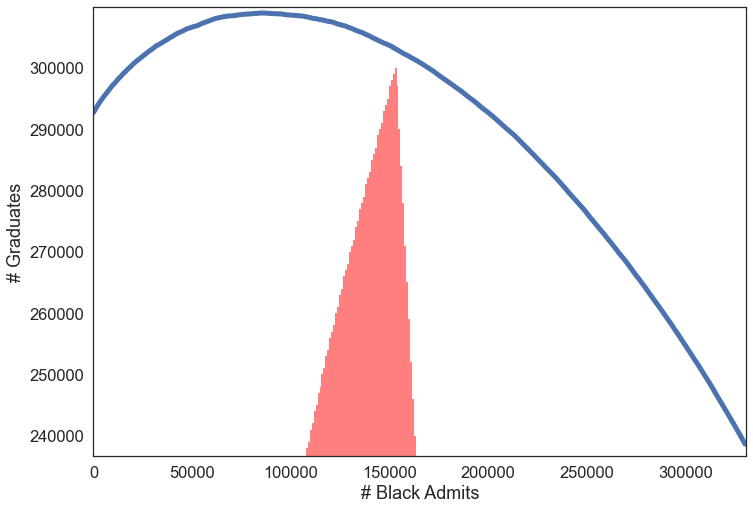

In [43]:
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="white", font_scale=1.5, )
ax = sns.lineplot(data=df_pareto, x='# Black Admits', y='# Graduates',linewidth=5)
errorboxes = []

for outcome_block in outcomes_grid:
    if outcome_block['policy_exists'] == 1:
        errorboxes.append(Rectangle((outcome_block['min_black_admits'] , outcome_block['min_graduates']),GRID_SIZE,GRID_SIZE))

pc = PatchCollection(errorboxes, facecolor='red', alpha=0.5,  edgecolor='none')
                       
ax.add_collection(pc)
plt.scatter(x=(df['R']*0.5).sum(),y=(df['Y']*0.5).sum(),color='green')   
plt.xlim([0, MAX_BLACK_ADMITS])
plt.ylim([df_pareto['# Graduates'].min()-2000, df_pareto['# Graduates'].max()+1000])
plt.show()


    


In [34]:
# Show utility maximizing policy 
acceptable_policies = [x for x in outcomes_grid if x['policy_exists']==1]
best_outcome = acceptable_policies[0]
for outcome in acceptable_policies:
    if outcome['max_graduates'] - 22000 < 100 and outcome['max_black_admits'] - 11000 < 100:
        best_outcome = outcome

In [35]:
constrain_graduate.SetBounds(float(21900), float(22000))
constrain_black_admit.SetBounds(float(10950.0), float(11050.0))
status = solver.Solve()
status

0

In [36]:
row = []
admit = []

for i in applicant_stratum:
    row.append(int(str(i)))
    admit.append(i.solution_value())


In [37]:
#row = best_outcome['policy'][0]
#admit = best_outcome['policy'][1]


df_decisions = pd.DataFrame({'row_id':row,'decision':admit})

dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='N',ascending=False)
viz = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='N',ascending=False)[['R','T','Y','decision']]



<AxesSubplot:xlabel='T', ylabel='decision'>

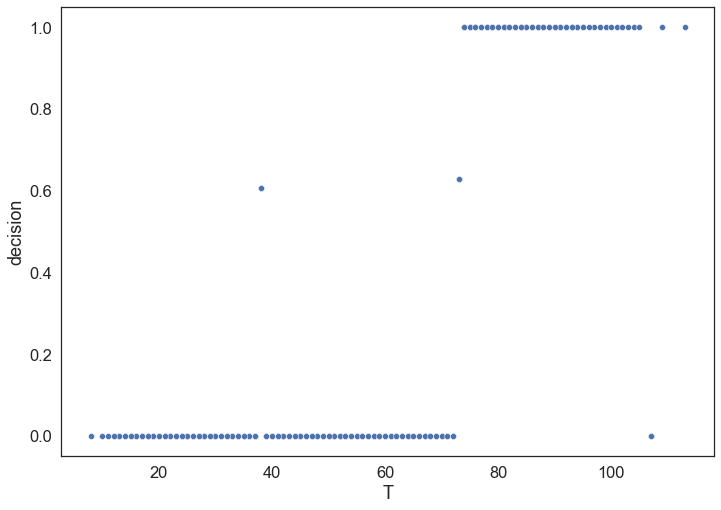

In [38]:
sns.scatterplot(data= viz[viz['R']==1], x='T',y='decision')

<AxesSubplot:xlabel='T', ylabel='decision'>

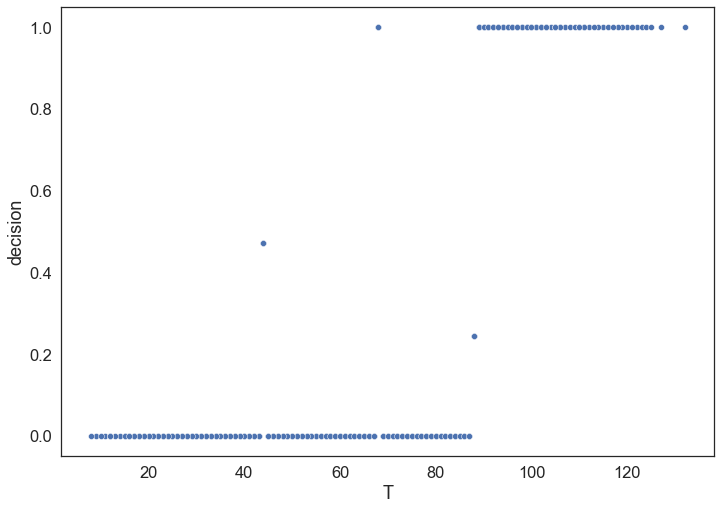

In [39]:
sns.scatterplot(data= viz[viz['R']==0], x='T',y='decision')

In [40]:
df['key'] = df['R'].astype(str)+'_'+df['T'].astype(str)+'_'+df['Y'].astype(str)
viz['key'] = viz['R'].astype(str)+'_'+viz['T'].astype(str)+'_'+viz['Y'].astype(str)

admit_decisions = df.merge(viz[['key','decision']],how='left',on='key')
admit_decisions['decision_random'] = pd.Series([random.random() for x in range(0,len(admit_decisions))]) < FRAC_ADMIT

NUM_MINORITY_POLICY = (admit_decisions['R'] * admit_decisions['decision']).sum()
SUM_BP_POLICY = ( admit_decisions['Y'] * admit_decisions['decision']).sum()

NUM_MINORITY_RANDOM = (admit_decisions['R'] * admit_decisions['decision_random']).sum()
SUM_BP_RAND_POLICY = ( admit_decisions['Y'] * admit_decisions['decision_random']).sum()

In [41]:
SUM_BP_POLICY, NUM_MINORITY_POLICY

(22000.000000000004, 11050.0)

In [42]:
admit_decisions

,Unnamed: 0,R,E_noise,E_minority,E_majority,M_noise,M_minority,M_majority,T_noise,T_minority,T_majority,T_majority_star,T_minority_star,E,M,T,Y_unif,Y_reject_noise,Y,Y_raw,Y_reject,Y_reject_raw,key,stratum_utility,utility_grad,ml_outcomes,decision,decision_random
0,1,0,-1.542325,-1.542325,-0.542325,-0.870181,-3.412506,-2.412506,5.202832,41,45,41,43,-0.542325,-2.412506,45,0.405195,-0.998808,0,0.082224,0,0.051539,0_45_0,0.32,0.32,0.32,0.0,False
1,287,0,0.033548,0.033548,1.033548,-1.653270,-2.619722,-1.619722,-0.672222,39,45,40,43,1.033548,-1.619722,45,0.220107,-0.173954,0,0.165243,0,0.107195,0_45_0,0.32,0.32,0.32,0.0,False
2,355,0,-2.009058,-2.009058,-1.009058,0.954792,-2.054266,-1.054266,2.571658,40,45,42,42,-1.009058,-1.054266,45,0.007614,-0.741538,1,0.258407,1,0.174471,0_45_1,0.32,0.32,0.32,0.0,True
3,387,0,-1.236377,-1.236377,-0.236377,-0.085102,-2.321479,-1.321479,0.864577,40,45,41,42,-0.236377,-1.321479,45,0.588465,-0.372447,0,0.210572,0,0.139256,0_45_0,0.32,0.32,0.32,0.0,True
4,388,0,-0.449965,-0.449965,0.550035,-0.317339,-1.767304,-0.767304,-3.919019,38,45,40,42,0.550035,-0.767304,45,0.007656,-1.295341,1,0.317063,1,0.219719,0_45_1,0.32,0.32,0.32,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,674539,0,4.348970,4.348970,5.348970,1.185237,4.534207,5.534207,4.188430,109,127,118,118,5.348970,5.534207,127,0.568382,-0.864262,1,0.996066,1,0.993531,0_127_1,1.00,1.00,1.00,1.0,True
999996,701098,0,3.509653,3.509653,4.509653,1.923563,4.433216,5.433216,9.973584,107,124,116,115,4.509653,5.433216,124,0.873798,-0.408289,1,0.995650,1,0.992848,0_124_1,1.00,1.00,1.00,1.0,False
999997,761250,0,2.968213,2.968213,3.968213,2.117500,4.085713,5.085713,17.632893,108,124,116,115,3.968213,5.085713,124,0.960404,-0.822453,1,0.993854,1,0.989906,0_124_1,1.00,1.00,1.00,1.0,True
999998,718460,0,3.532001,3.532001,4.532001,0.244317,2.776318,3.776318,31.511730,117,132,123,124,4.532001,3.776318,132,0.403163,-0.719859,1,0.977606,1,0.963607,0_132_1,1.00,1.00,1.00,1.0,True
